Clothing_Categorization

Parker Williamson
1/22/2018

This program takes a set of training data and classification data and using different methods of computer vision categorizes the test set based on the training set. The data that was used to analyze different techniques was clothing data from https://www.kaggle.com/zalando-research/fashionmnist.

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import csv
import pandas as pd
from numpy import genfromtxt
from sklearn.neural_network import MLPClassifier
from sklearn import svm
from sklearn import preprocessing
from sklearn.linear_model import LogisticRegression
from scipy import stats

In [9]:
%matplotlib inline

Dictionary definitions shows the true categories that the dataset lists

In [2]:
definitions = {0:'T-shirt/top',1:'Trouser',2:'Pullover',3:'Dress',4:'Coat',5:'Sandal',6:'Shirt',7:'Sneaker',8:'Bag',9:'Ankle boot'}

open data from the adjacent rawData folder

In [4]:
train_data = genfromtxt('rawData/fashion-mnist_train.csv', skip_header=True, delimiter=',')

In [7]:
test_data = genfromtxt('rawData/fashion-mnist_test.csv', skip_header=True, delimiter=',')

In [3]:
#plt.imshow(train_data[6][1:785].reshape((28,28)))
#plt.show()

In [8]:
classification,rawData =np.split(train_data,indices_or_sections=[1],axis=1)

In [32]:
#plt.hist(rawData[0][:],range=(0,255),bins=25)
#plt.show()

In [ ]:
for image in range(int(len(rawData))):
    print('Image {}: mean {}'.format(image,rawData[image][:].mean()))
    plt.hist(rawData[image][:],range=(0,255),bins=25)
    plt.show()

Select preprocessing mode

In [52]:
mode=''

In [ ]:
if mode=='Normalize':
    preclassifier_data = preprocessing.normalize(rawData)
elif mode=='Standardize':
    preclassifier_data = (rawData - np.mean(rawData, axis=1, keepdims=1)) / np.std(rawData, axis=1, keepdims=1)
else:
    preclassifier_data = rawData

In [ ]:
classifier= 'SVC'
print('classifier: {}'.format(classifier))
if classifier=='MLP':
    clf = MLPClassifier(solver='adam', alpha=1e-5, hidden_layer_sizes=(784, 100, 100), random_state=1)
    clf.fit(preclassifier_data, classification.ravel())
#note svc takes forever...    :(
elif classifier=='SVC':
    clf = svm.SVC()
    clf.fit(preclassifier_data, classification.ravel())
elif classifier=='LinReg':
    clf = LogisticRegression()
    clf.fit(preclassifier_data, classification.ravel())

In [55]:
classification_test,rawData_test =np.split(test_data,indices_or_sections=[1],axis=1)

In [56]:
if mode=='Normalize':
    preclassifier_data_test = preprocessing.normalize(rawData_test)
elif mode=='Standardize':
    preclassifier_data_test = (rawData_test - np.mean(rawData_test, axis=1, keepdims=1)) / np.std(rawData_test, axis=1, keepdims=1)
else:
    preclassifier_data_test = rawData_test

In [57]:
results = clf.predict(preclassifier_data_test)

In [58]:
print(results)
print(len(results))
print(len(classification_test))

[ 0.  1.  2. ...,  8.  6.  4.]
10000
10000


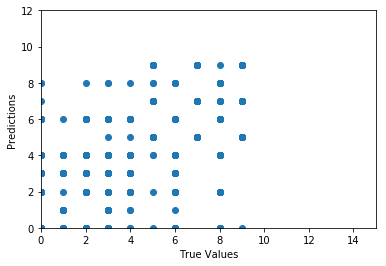

In [59]:
## The line / model
#%pylab inline
plt.scatter(classification_test, results)
plt.xlabel('True Values')
plt.ylabel('Predictions')
plt.axis([0, 15, 0, 12])
plt.show()

In [60]:
comp= np.equal(list(classification_test.ravel()), list(results))
#print(comp.shape)
#print(classification_test.ravel())
#print(results)
print(comp)
print(comp.sum())
print('Percentage: {}'.format(100*(comp.sum()/(len(comp)))))

[ True  True  True ...,  True False False]
8765
Percentage: 87.64999999999999
